In [1]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
from pathlib import Path
%matplotlib inline

## Loading data

In [2]:
img_size = 64
batch_size=64
lr = 0.0002
beta1 = 0.5
niter= 25
outf= 'output'

path = Path('../../ml_data/')


In [4]:
dataset = datasets.CIFAR10( root = path, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size,
                                         shuffle=True)

In [5]:
#Size of latnet vector
nz = 100
# Filter size of generator
ngf = 64
# Filter size of discriminator
ndf = 64
# Output image channels
nc = 3

# Network Initialization

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator

In [7]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output


netG = _netG()
netG.apply(weights_init)
print(netG)

_netG(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [8]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


netD = _netD()
netD.apply(weights_init)
print(netD)

_netD(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Defining loss functions

In [9]:

criterion = nn.BCELoss()

input = torch.FloatTensor(batch_size, 3, img_size, img_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [10]:
if torch.cuda.is_available():
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

# Defining optimiser

In [11]:
fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

# Training 

In [14]:

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

[0/25][0/782] Loss_D: 0.8986 Loss_G: 6.2352 D(x): 0.7505 D(G(z)): 0.3633 / 0.0028
[0/25][1/782] Loss_D: 0.9127 Loss_G: 6.3755 D(x): 0.7241 D(G(z)): 0.3242 / 0.0024
[0/25][2/782] Loss_D: 0.9840 Loss_G: 5.9923 D(x): 0.6337 D(G(z)): 0.2551 / 0.0033
[0/25][3/782] Loss_D: 0.9236 Loss_G: 6.5489 D(x): 0.7107 D(G(z)): 0.3007 / 0.0020
[0/25][4/782] Loss_D: 0.6420 Loss_G: 7.6998 D(x): 0.8139 D(G(z)): 0.2936 / 0.0006
[0/25][5/782] Loss_D: 0.4790 Loss_G: 8.0436 D(x): 0.8479 D(G(z)): 0.2223 / 0.0005
[0/25][6/782] Loss_D: 0.6237 Loss_G: 9.0877 D(x): 0.8380 D(G(z)): 0.2937 / 0.0002
[0/25][7/782] Loss_D: 0.6447 Loss_G: 8.1836 D(x): 0.7734 D(G(z)): 0.1765 / 0.0004
[0/25][8/782] Loss_D: 0.8728 Loss_G: 11.3004 D(x): 0.8487 D(G(z)): 0.4208 / 0.0000
[0/25][9/782] Loss_D: 0.5503 Loss_G: 8.0969 D(x): 0.7065 D(G(z)): 0.0234 / 0.0005
[0/25][10/782] Loss_D: 1.2262 Loss_G: 11.9180 D(x): 0.7870 D(G(z)): 0.4977 / 0.0000
[0/25][11/782] Loss_D: 0.2958 Loss_G: 9.2999 D(x): 0.8317 D(G(z)): 0.0351 / 0.0002
[0/25][12/78

In [15]:
mkdir output

mkdir: cannot create directory ‘output’: File exists


In [16]:
ls -al output/

total 11892
drwxrwxr-x 2 walle walle   4096 Jan 25 13:45 ./
drwxrwxr-x 5 walle walle   4096 Jan 30 01:12 ../
-rw-rw-r-- 1 walle walle 568544 Jan 30 00:52 fake_samples_epoch_000.png
-rw-rw-r-- 1 walle walle 495281 Jan 30 00:53 fake_samples_epoch_001.png
-rw-rw-r-- 1 walle walle 477496 Jan 30 00:54 fake_samples_epoch_002.png
-rw-rw-r-- 1 walle walle 478484 Jan 30 00:54 fake_samples_epoch_003.png
-rw-rw-r-- 1 walle walle 449180 Jan 30 00:55 fake_samples_epoch_004.png
-rw-rw-r-- 1 walle walle 470282 Jan 30 00:56 fake_samples_epoch_005.png
-rw-rw-r-- 1 walle walle 451897 Jan 30 00:57 fake_samples_epoch_006.png
-rw-rw-r-- 1 walle walle 458757 Jan 30 00:57 fake_samples_epoch_007.png
-rw-rw-r-- 1 walle walle 445624 Jan 30 00:58 fake_samples_epoch_008.png
-rw-rw-r-- 1 walle walle 598458 Jan 30 00:59 fake_samples_epoch_009.png
-rw-rw-r-- 1 walle walle 502785 Jan 30 01:00 fake_samples_epoch_010.png
-rw-rw-r-- 1 walle walle 450594 Jan 30 01:00 fake_samples_epoch_011.png
-rw-rw-r-- 1 walle walle 46

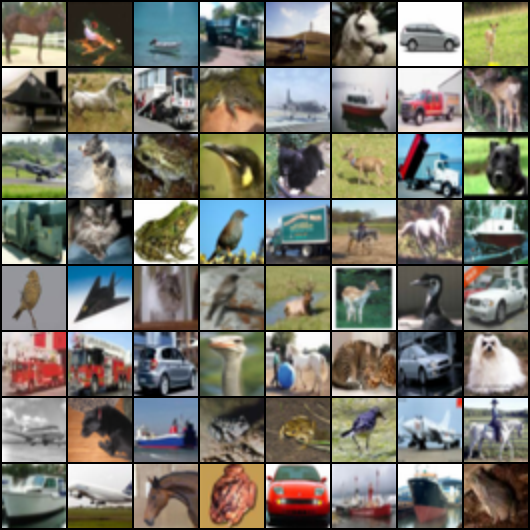

In [17]:
Image.open('output/real_samples.png')

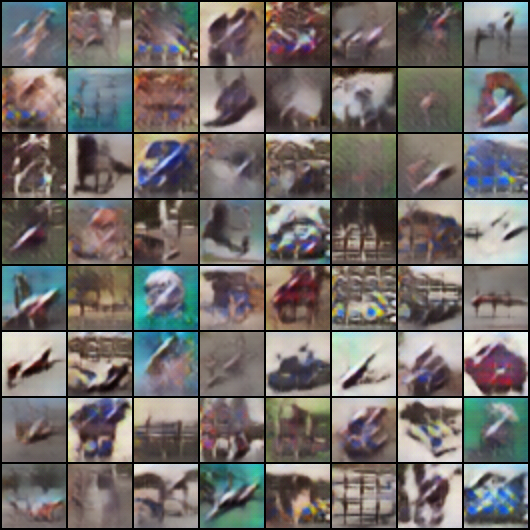

In [18]:
Image.open('output/fake_samples_epoch_024.png')